In [217]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from firthlogist import FirthLogisticRegression


class QLearningModule:
    def __init__(self, lr, rl_temp, n_states, n_actions, q0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.lr = lr
        self.rl_temp = rl_temp
        self.q = np.ones((n_states, n_actions)) * q0
    
    def rl_learn(self, s, a, r):
        self.q[s, a] += self.lr * (r - self.q[s, a])


class PerceptualModule:
    def __init__(self, perceptual_temp, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.perceptual_temp = perceptual_temp
    
    def get_p_destroy(self, hist_s, hist_r, s1, s2, x=np.arange(0, 11)):
        if len(hist_s) == 0:
            return [0.5, 0.5]

        # hist_r = np.array(hist_r)
        # hist_s = np.array(hist_s)

        # return FirthLogisticRegression(skip_ci=True, wald=True)\
            # .fit(sm.add_constant(hist_s), hist_r).predict(sm.add_constant(x))[[s1, s2]]
        return sm.Logit(hist_r, sm.add_constant(hist_s))\
                .fit().predict(sm.add_constant(x))[[s1, s2]]
    
    def get_p_destroy_full(self, hist_s, hist_r):
        if len(hist_s) == 0:
            return [0.5, 0.5]

        return sm.Logit(hist_r, sm.add_constant(hist_s))\
                .fit().predict(sm.add_constant(np.unique(hist_s)))
    

    def get_params(self, s, r):
        return sm.Logit(r, s).fit().params
    

class HybridModel(QLearningModule, PerceptualModule):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def make_choice(self, sr, hist_sp, hist_rp, sp1, sp2):

        def logsumexp(x):
            c = x.max()
            return c + np.log(np.sum(np.exp(x - c)))

        def normalize(x):
            # between 0 and 1
            return (x - np.min(x)) / (np.max(x) - np.min(x))

        x = ((self.q[sr, :] * self.rl_temp)
             * (self.get_p_destroy(hist_sp, hist_rp, sp1, sp2)
             * self.perceptual_temp))

        p = np.exp(x - logsumexp(x))

        return np.random.choice(np.arange(2), p=p)



class KalmanFilter:
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def 

        
h = HybridModel(lr=1, rl_temp=5, perceptual_temp=5, n_states=2, n_actions=2, q0=50)

Optimization terminated successfully.
         Current function value: 0.419264
         Iterations 6


c:\Users\basil\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot: >

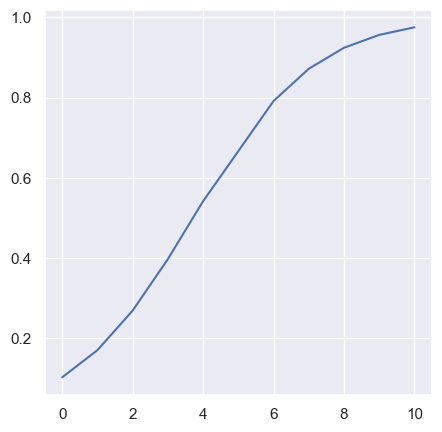

In [218]:
# perceptual training
# -----------------------------------------------------------------
n_perceptual_trials_per_color = 3
# states (colors coded by real probability of destroying the target)
sp = np.array(
    [np.linspace(0, 1, 10).round(1) for _ in range(n_perceptual_trials_per_color)]
    ).flatten()
# rewards (1 if target destroyed, 0 otherwise), using the real probabilities in s
rp = np.array(
    [np.random.binomial(1, sp[i]) for i in range(len(sp))]
    ).flatten()
# s.shape, r.shape

x = np.unique(sp*10)
y = h.get_p_destroy_full(sp*10, rp)

#small figure
sns.set(rc={'figure.figsize':(5,5)})
sns.lineplot(x, y)

In [219]:
# -----------------------------------------------------------------
# Full
# -----------------------------------------------------------------
# np.random.seed(0)

conditions = [
    [60, 40],
    [90, 10]
]
std = 5

n_trials_per_condition = 50
conditions_idx = np.repeat(np.arange(len(conditions)), n_trials_per_condition)
ff1 = np.random.randint(0, 11, n_trials_per_condition*2)
ff2 = np.random.randint(0, 11, n_trials_per_condition*2)

p_ff = np.linspace(0, 1, 11)

ntrials = len(conditions_idx)
hist_sp = list(sp*10)
hist_rp = list(rp)
# hist_rp = []
# hist_sp = []

df_list = []

nagents = 50

lr = np.random.uniform(0, 1, nagents)
rl_temp = np.random.normal(2, .8, nagents)
perceptual_temp = np.random.normal(2, .8, nagents)

# removes negative values and values > 1
lr[lr < 0] = 0
lr[lr > 1] = 1

rl_temp[rl_temp < 0] = 0
perceptual_temp[perceptual_temp < 0] = 0

agents = []

for agent in range(nagents):

    h = HybridModel(
            lr=lr[agent],
            rl_temp=rl_temp[agent],
            perceptual_temp=perceptual_temp[agent],
            n_states=2,
            n_actions=2,
            q0=np.mean(conditions)
    )
    agents.append(h)

    for t in range(ntrials):

        s_rl = conditions_idx[t]

        sp1 = ff1[t]
        sp2 = ff2[t]
        
        a = h.make_choice(s_rl, hist_sp, hist_rp, sp1, sp2)

        r = np.random.normal(conditions[s_rl][a], std) 

        chosen_ff = sp1 if a == 0 else sp2
        unchosen_ff = sp2 if a == 0 else sp1

        destroyed = np.random.random() < p_ff[chosen_ff]
        
        if destroyed:
            h.rl_learn(s_rl, a, r)

        # add chosen ff to history
        hist_sp.append(chosen_ff)
        hist_rp.append(destroyed)
        
        #check that the model chose the best ff
        corr_ff = p_ff[chosen_ff] > p_ff[unchosen_ff]
        corr_rl = a == 0 

        unchosen = 1 if a == 0 else 0

        ev_chosen = conditions[s_rl][a] * p_ff[chosen_ff]
        ev_unchosen = conditions[s_rl][unchosen] * p_ff[unchosen_ff]

        df_list.append({
            'trial': t,
            'chosen_ff': chosen_ff,
            'unchosen_ff': unchosen_ff,
            'choice': a,
            'unchosen': unchosen,
            'correct_ff': corr_ff,
            'correct_rl': corr_rl,
            'correct_full':ev_chosen > ev_unchosen,
            'agent': agent
        })

df = pd.DataFrame(df_list)



Optimization terminated successfully.
         Current function value: 0.419264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408205
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.454947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442480
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434870
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.450132
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.439426
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.430295
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438648
  

(0.0, 1.0)

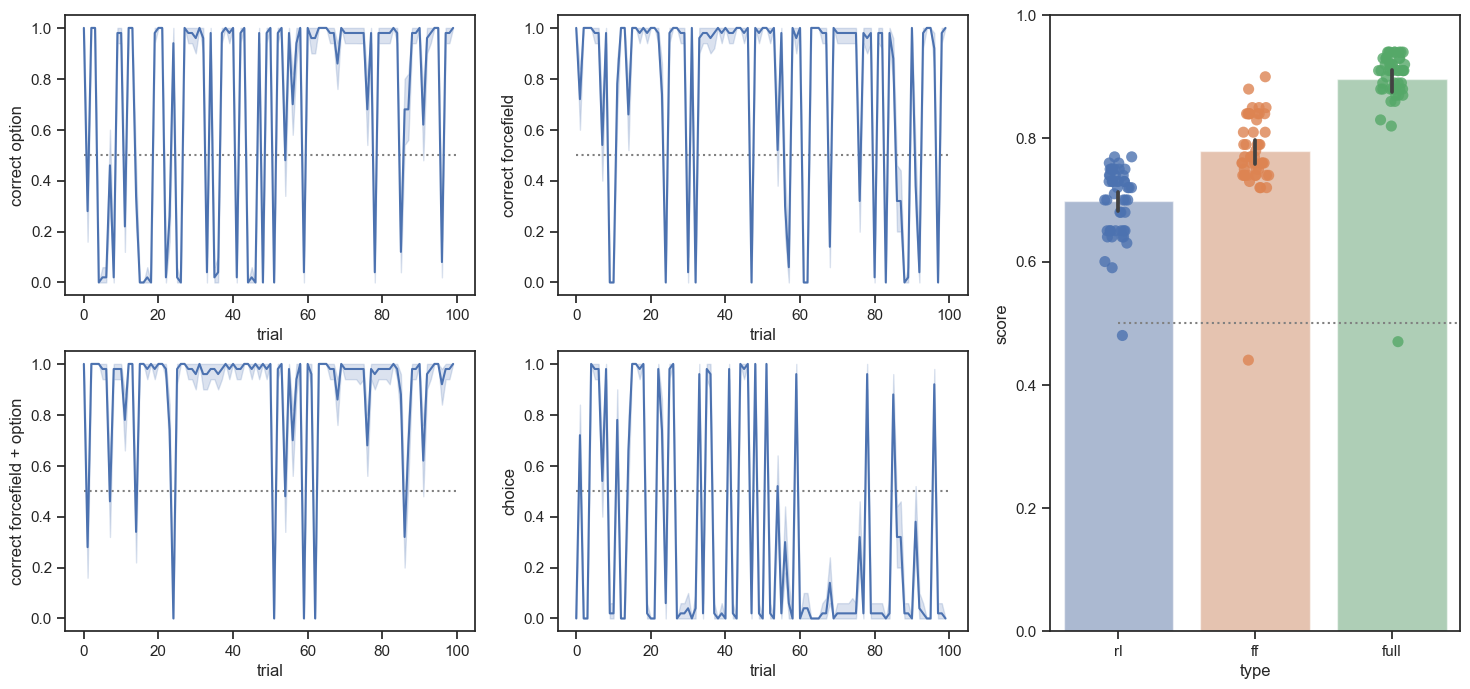

In [222]:
sns.set({'figure.figsize': (18, 8)})
sns.set_style('ticks')

plt.subplot(2, 3, 1)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='correct_rl', data=df)
plt.ylabel('correct option')

plt.subplot(2, 3, 2)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='correct_ff', data=df)
plt.ylabel('correct forcefield')

plt.subplot(2, 3, 4)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='correct_full', data=df)
plt.ylabel('correct forcefield + option')

plt.subplot(2, 3, 5)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='choice', data=df)
plt.ylabel('choice')

plt.subplot(1, 3, 3)
# plot dotted line at .5
plt.plot([0, 3], [.5, .5], color='grey', linestyle=':')
avg = df.groupby('agent').mean()
# 1s column = score, 2nd colum type ('rl', 'ff', 'full')
new_df = pd.DataFrame({'score': np.array([avg['correct_rl'], avg['correct_ff'], avg['correct_full']]).flatten(), 'type': np.array(
    ['rl',] * len(avg['correct_rl'])
    + ['ff',] * len(avg['correct_ff'])
    + ['full',] * len(avg['correct_full'])).flatten()})

sns.barplot(x='type', y='score', data=new_df,alpha=.5, zorder=0)
sns.stripplot(x='type', y='score', data=new_df, jitter=True, alpha=.8, size=8, zorder=1)
plt.ylim(0,1)


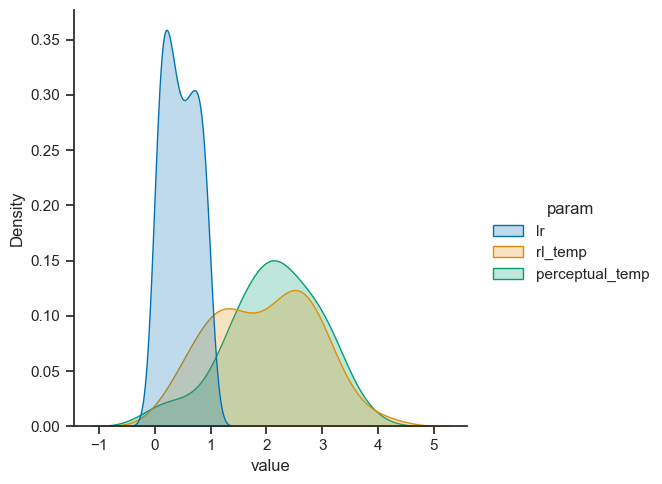

In [223]:
#plot the distribution of model parameters
sns.set({'figure.figsize':(11,8)})
sns.set_style('ticks')

params = pd.DataFrame(
    {
        'param': np.array(
            ['lr', ] * nagents
          + ['rl_temp', ] * nagents
          + ['perceptual_temp', ] * nagents
        ).flatten(),
        'value': np.array(
            [agent.lr for agent in agents]
          + [agent.rl_temp for agent in agents]
          + [agent.perceptual_temp for agent in agents]
        ).flatten(),
    }
)

sns.displot(
    data=params,
    x='value',
    hue='param',
    kind='kde',
    fill=True,
    palette='colorblind',
)

In [225]:
import numpy as np

# Define the state update equation
def state_update(A, B, x_k, u_k, n_k):
    return np.dot(A, x_k) + np.dot(B, u_k) + n_k

# Define the observation equation
def observation_eq(C, x_k, n_k):
    return np.dot(C, x_k) + n_k

# Define the Kalman filter update step
def kalman_filter_update(x_k, P_k, C, y_k, s2_y):
    K = np.dot(P_k, C.T) / (np.dot(np.dot(C, P_k), C.T) + s2_y)
    x_k_next = x_k + np.dot(K, y_k - np.dot(C, x_k))
    P_k_next = np.dot((np.eye(len(x_k)) - np.dot(K, C)), P_k)
    return x_k_next, P_k_next

# Define the extended state of the system
def extended_state_update(A, B, x_k, u_k, n_k):
    return state_update(A, B, x_k, u_k, n_k)

# Define the optimal policy
def optimal_policy(u_k, perturbation_estimate, w_k, nn):
    return perturbation_estimate * w_k + nn * u_k

# Define the reward function
def reward_function(u_k, c_k_1, goal_area, b):
    if c_k_1 < goal_area:
        return 1.0 - b * u_k**2
    else:
        return -b * u_k**2

# Main simulation function
def simulate_kalman_filter(A, B, C, Vx, s2_h, s2_p, s2_y, nn, N, goal_area, b):
    x_k = np.zeros(2)  # Initial state [perturbation, hand position]
    P_k = np.eye(2) * Vx  # Initial state covariance matrix

    perturbation_estimate = 0.0

    for k in range(N):
        u_k = np.random.normal(0, 1)  # Generate motor command (control input)
        n_h = np.random.normal(0, s2_h)  # Motor command noise
        n_p = np.random.normal(0, s2_p)  # Perturbation noise
        n_y = np.random.normal(0, s2_y)  # Observation noise

        # State prediction (extended state)
        x_k_next = extended_state_update(A, B, x_k, u_k, n_h)

        # Update observation
        y_k = observation_eq(C, x_k_next, n_y)

        # Kalman filter update
        x_k, P_k = kalman_filter_update(x_k_next, P_k, C, y_k, s2_y)

        # Estimate perturbation using Eq. (5)
        perturbation_estimate = 0.8 * perturbation_estimate + 0.2 * x_k[0]

        # Update policy using Eq. (13)
        w_k = np.random.normal(0, 1)  # Active search noise
        u_k_next = optimal_policy(u_k, perturbation_estimate, w_k, nn)

        # Calculate reward using Eq. (14)
        c_k_1 = x_k_next[1]
        reward = reward_function(u_k, c_k_1, goal_area, b)

        # Update the policy weights using TD error learning
        delta_k = reward + b * c_k_1**2 - np.dot(w_k, x_k)  # Reward prediction error
        v = 0.8 * v + 0.2 * delta_k  # Update value estimate
        r = 0.8 * r + 0.2 * delta_k * nn  # Update reward prediction

    return x_k[1]  # Return the final hand position after N trials

# Simulation parameters
A = np.array([[0, 1], [0, 0]])  # State transition matrix
B = np.array([[0], [1]])  # Control input matrix
C = np.array([[0, 1]])  # Observation matrix
s2_h = 0.1  # Variance of hand position noise
s2_p = 0.05  # Variance of perturbation noise
s2_y = 0.01  # Variance of observation noise
nn = 0.1  # Active search noise
N = 100  # Number of trials
goal_area = 10.0  # Goal area for reward function
b = 0.1  # Scaling parameter of the motor cost
Vx = np.array([[s2_p, 0], [0, s2_h]])  # State covariance matrix

# Run the simulation
final_hand_position = simulate_kalman_filter(A, B, C, Vx, s2_h, s2_p, s2_y, nn, N, goal_area, b)
print("Final hand position after {} trials: {}".format(N, final_hand_position))


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()